In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as matplotlib
import numpy as np

In [3]:
def show_plot(file_name):
  data = np.loadtxt(file_name, dtype=np.float64, unpack=True).T
  print(data)
  fig, ax = plt.subplots(ncols=2, figsize=(10, 7))
  ax[0].plot(data[:, 0], data[:, 1], label='Линейный алгоритм')  
  ax[0].scatter(data[:, 0], data[:, 1], marker="+")
  ax[0].plot(data[:, 0], data[:, 2])  
  ax[0].scatter(data[:, 0], data[:, 2], marker="+")
  ax[0].set_xlabel('количество потоков')
  ax[0].set_ylabel('Время[мс]')
  ax[0].set_title('Время работы')
  ax[0].grid()
  ax[1].plot(data[:, 0], data[0, 1] / data[:, 1], label='Параллельный алгоритм')
  ax[1].scatter(data[:, 0], data[0, 1] / data[:, 1], marker="+")
  ax[1].plot(data[:, 0], data[0, 1] / data[:, 2])  
  ax[1].scatter(data[:, 0], data[0, 1] / data[:, 2], marker="+")
  ax[1].set_xlabel('количество потоков')
  ax[1].set_ylabel('Ускорение')
  ax[1].set_title('Ускорение в зависимости от числа исполнителей')
  ax[1].grid()
  plt.show()

# Теоретические сведения
## Условия Бернстайна
Пусть в программе имеются два оператора S1 и S2,
непосредственно динамически следующих друг за другом. Пусть
W(S) – набор выходных переменных оператора S, а R(S) – набор его
входных переменных. Тогда возможность их одновременного
выполнения различными исполнителями в параллельной системе
можно определить с помощью условий Бернстайна.
Если для операторов S1 и S2, непосредственно
динамически следующих друг за другом, выполнено:
 - пересечение W(S1) и W(S2) пусто;
 - пересечение W(S1) и R(S2) пусто;
 - пересечение R(S1) и W(S2) пусто;
то они могут быть исполнены параллельно.

## Зависимости в циклах
```cpp
for (int i=0; i < i_fin; ++i) {
  S1: A[f(i)] = 
  S2: ... = A[g(i)]...
}
```

- S1 - запись
- S2 - чтение

Пусть:
$$
1 <= \lambda <= i_{fin}
$$

$$
1 <= \kappa <= i_{fin} 
$$

$$
f(\lambda) == g(\kappa)
$$

Тогда оюозначим:

$$
D = \lambda - \kappa
$$

- S1 - source
- S2 - sink
- D - расстояние зависимости цикла

Типы зависимостей:
- $D < 0$ - антизависимость (read after write)
- $D > 0$ - потоковая зависимость (write after read)



# Задания к допуску
## Вариант
Необходимо сделать 1г, 2г, 3г

## Векторы направлений и расстояний
`1г MPI`:
```cpp
for (i = 3; i < ISIZE; i++)
  for (j = 0; j < JSIZE - 2; j++)
    a[i][j] = sin(3 * a[i - 3][j + 2]);
```
Вектор функции источника и стока соответственно:
$$
F =
\begin{pmatrix}
  i \\
  j
\end{pmatrix}

G =
\begin{pmatrix}
  i' - 3 \\
  j' + 2
\end{pmatrix}
$$

Вектор расстояний:
$$
D = 
\begin{pmatrix}
  3 \\
  -2
\end{pmatrix}
$$

Вектор направлений:
$$
d = 
\begin{pmatrix}
  < \\
  >
\end{pmatrix}
$$

Тип - антизависимость

В данном векторе направлений нету зависимости =, поэтому распараллеливание придется проводить с ограничениями.

По внешнему циклу зависимость прямая. По внутреннему анти.

Если убрать слип в операции, то не получится получить ускорение из-за того что вычисление синуса быстрее чем копирование.

`2г OpenMP`:
```cpp
for (i = 0; i < ISIZE - 3; i++)
  for (j = 2; j < JSIZE; j++)
    a[i][j] = sin(0.1 * a[i + 3][j - 2]);
```

Вектор расстояний:
$$
D = 
\begin{pmatrix}
  -3 \\
  2
\end{pmatrix}
$$

Вектор направлений:
$$
d = 
\begin{pmatrix}
  > \\
  <
\end{pmatrix}
$$

В данном случае есть истинная зависимость по данным.

Надо распараллелть внешний цикл и скопировать 3 линии после i.

`3г OpenMP`:

Достаточно просто поставить барьерную синхронизацию между циклами


```cpp
for (i = 0; i < ISIZE; i++)
  for (j = 0; j < JSIZE; j++)
    a[i][j] = sin(0.005 * a[i][j]);

for (i = 5; i < ISIZE; i++)
  for (j = 0; j < JSIZE - 2; j++)
    b[i][j] = a[i - 5][j + 2] * 1.5;
```


```cpp
// однопоточная обработка
for (i = ISIZE - 5; i < ISIZE; i++)
  for (j = 0; j < 2; j++)
    a[i][j] = sin(0.005 * a[i - 5][j + 2]);

// многопоточная
for (i = 5; i < ISIZE; i++)
  for (j = 0; j < JSIZE - 2; j++)
    b[i][j] =  a[i - 5][j + 2] * 1.5;
```

# Результаты
## Задание 1

В данном случае были проведены измерения с более долгой операцией(слип в функции вычисления клетки):

[[1.000e+00 1.516e+03 1.516e+03]
 [2.000e+00 1.516e+03 7.740e+02]
 [3.000e+00 1.516e+03 5.190e+02]
 [4.000e+00 1.516e+03 4.060e+02]
 [5.000e+00 1.516e+03 3.360e+02]
 [6.000e+00 1.516e+03 2.740e+02]]


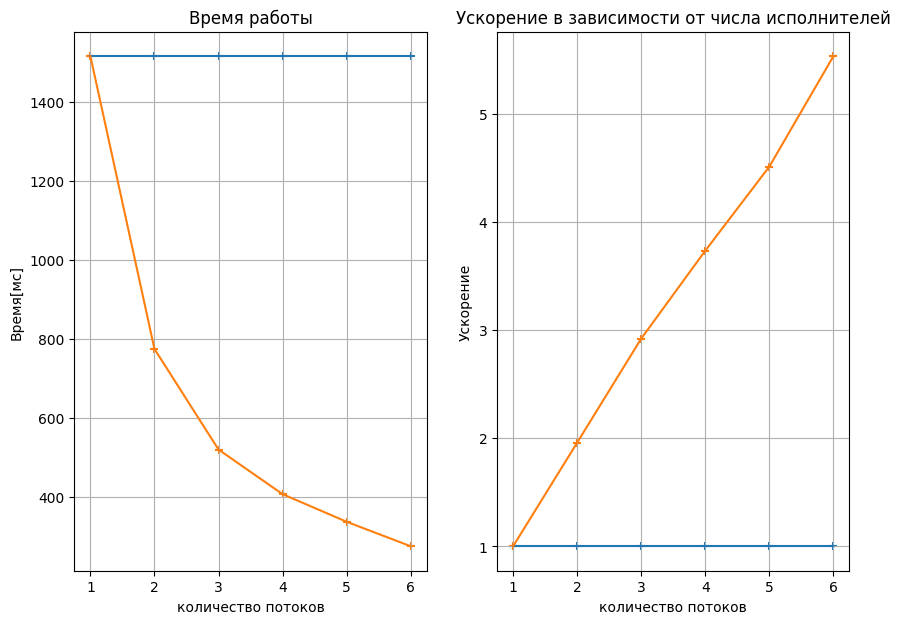

In [4]:
show_plot("1-g-time-threads.res")

И измерения со стандартной функцией:

[[1.000e+00 6.400e+02 2.494e+03]
 [2.000e+00 6.400e+02 1.659e+03]
 [3.000e+00 6.400e+02 1.443e+03]
 [4.000e+00 6.490e+02 1.266e+03]
 [5.000e+00 6.500e+02 1.244e+03]
 [6.000e+00 6.800e+02 1.176e+03]]


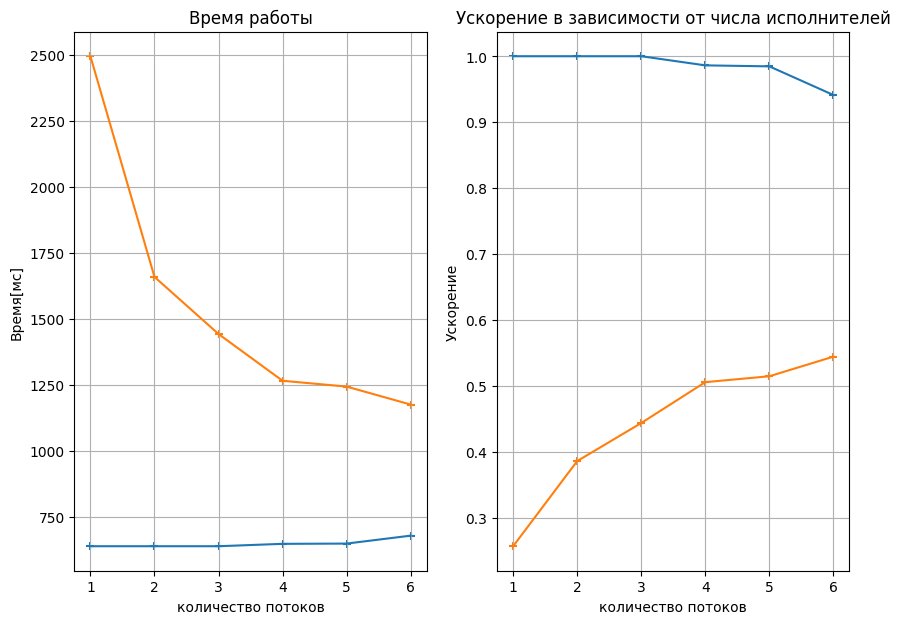

In [5]:
show_plot("1-g-time-threads-without-sleep.res")

Проблем заключается в колоборации данных. 
В однопоточном случае время объединения результатов составляет `981мс` при общем времени работы линейной версии `1257мс`.

## Задание 2

[[1.000e+00 1.130e+03 1.392e+03]
 [2.000e+00 1.125e+03 7.360e+02]
 [3.000e+00 1.123e+03 4.690e+02]
 [4.000e+00 1.211e+03 4.030e+02]
 [5.000e+00 1.088e+03 3.160e+02]
 [6.000e+00 1.121e+03 2.760e+02]]


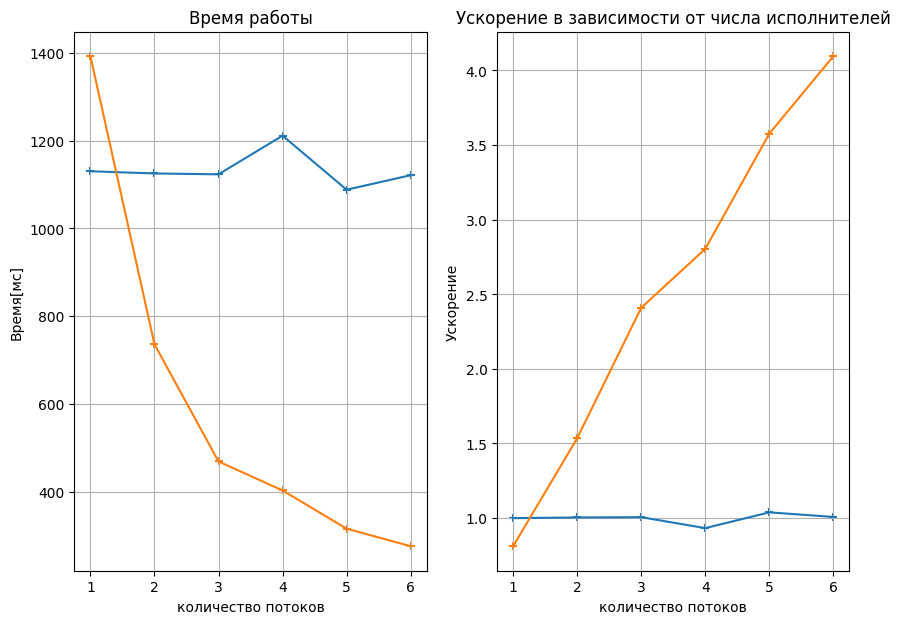

In [6]:
show_plot("2-g-time-threads-without-sleep.res")

## Задание 3

[[1.000e+00 1.710e+03 1.740e+03]
 [2.000e+00 1.815e+03 9.290e+02]
 [3.000e+00 1.818e+03 6.080e+02]
 [4.000e+00 1.814e+03 4.910e+02]
 [5.000e+00 1.724e+03 3.650e+02]
 [6.000e+00 1.763e+03 3.100e+02]]


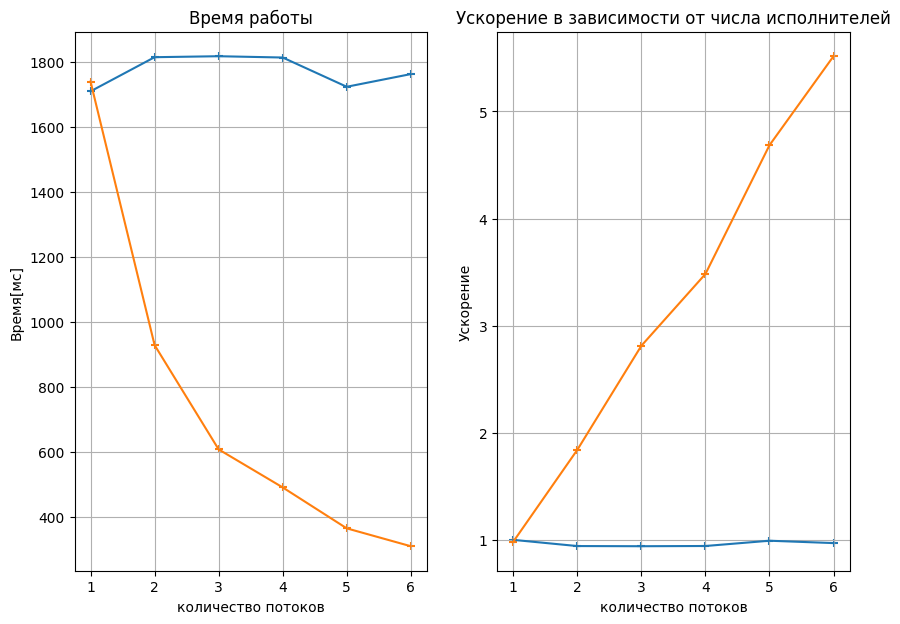

In [7]:
show_plot("3-g-time-threads-without-sleep.res")